In [1]:
import numpy as np
from models import hankel,rank

In [2]:
import pandas as pd
df = pd.read_csv('data/training_data.csv')
sensors = [3,9,25,43]
df = df.iloc[:, sensors]
df

,1_AIT_004_PV,1_MV_003_STATUS,2_FIC_401_CO,2_LS_101_AH
0,504.140,1.0,100.0000,0.0
1,504.140,1.0,100.0000,0.0
2,504.140,1.0,100.0000,0.0
3,504.140,1.0,100.0000,0.0
4,504.145,1.0,100.0000,0.0
...,...,...,...,...
971995,420.420,1.0,14.7983,0.0
971996,420.420,1.0,14.7983,0.0
971997,420.420,1.0,14.7983,0.0
971998,420.420,1.0,14.7983,0.0


In [3]:
X = df.iloc[:,0].values
X

array([504.14 , 504.14 , 504.14 , ..., 420.42 , 420.42 , 420.403])

In [4]:
han = hankel.Hankel()
temp = han.fit(X,30,0.5)
temp

array([[504.14 , 504.959, 505.273, ..., 468.106, 471.636, 474.392],
       [504.14 , 504.959, 505.273, ..., 468.106, 471.636, 474.392],
       [504.14 , 504.965, 505.273, ..., 468.106, 471.636, 474.392],
       ...,
       [505.251, 505.711, 505.997, ..., 474.358, 450.066, 426.824],
       [505.273, 505.711, 505.997, ..., 474.392, 450.066, 426.824],
       [505.273, 505.711, 505.997, ..., 474.392, 450.066, 426.672]])

In [5]:
temp.shape

(1800, 1078)

/home/manu/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


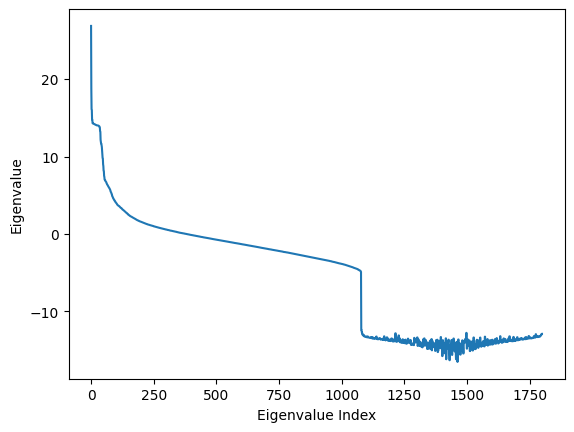

158

In [6]:
ran = rank.Rank()
r = ran.fit(temp)
r